# Everything before main

In [1]:
for t_other_agent in range(0, 10, 1):
    print(t_other_agent)

0
1
2
3
4
5
6
7
8
9


In [8]:
import os
from datetime import datetime
import time

import torch
from einops._torch_specific import allow_ops_in_compiled_graph  # requires einops>=0.6.1
from typing import Tuple, List

from torch_robotics.robots import *
from torch_robotics.torch_utils.torch_utils import get_torch_device
# from mmd.planners.multi_agent import CBS, PrioritizedPlanning
from mmd.planners.multi_agent import End2EndPlanning
from mmd.planners.single_agent import MPD, MPDEnd2End, MPDEnsemble
from mmd.common.constraints import MultiPointConstraint
from mmd.common.conflicts import PointConflict
from mmd.common.trajectory_utils import densify_trajs
from mmd.common import get_start_goal_pos_circle
from mmd.common.pretty_print import *
from mmd.config.mmd_params import MMDParams as params
from mmd.common.experiments import MultiAgentPlanningSingleTrialConfig, MultiAgentPlanningSingleTrialResult, \
    get_result_dir_from_trial_config, TrialSuccessStatus

allow_ops_in_compiled_graph()

TRAINED_MODELS_DIR = '../../data_trained_models/'
device = 'cuda'
device = get_torch_device(device)
tensor_args = {'device': device, 'dtype': torch.float32}

test_config_single_tile = MultiAgentPlanningSingleTrialConfig()
test_config_single_tile.num_agents = 3
test_config_single_tile.instance_name = "test"
# test_config_single_tile.multi_agent_planner_class = "XECBS" 
test_config_single_tile.single_agent_planner_class = "MPDe2e" # Or "MPDEnsemble"
test_config_single_tile.stagger_start_time_dt = 0
test_config_single_tile.runtime_limit = 60 * 3  # 3 minutes.
test_config_single_tile.time_str = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
test_config_single_tile.render_animation = True  # Change the `densify_trajs` call above to create nicer animations.

example_type = "single_tile"
# example_type = "multi_tile"
# ============================
# Single tile.
# ============================
if example_type == "single_tile":
    # Choose the model to use. A model is for a map/robot combination.
    # test_config_single_tile.global_model_ids = [['EnvEmpty2D-RobotPlanarDisk']]
    test_config_single_tile.global_model_ids = [['EnvEmptyNoWait2D-RobotPlanarDisk']]
    # test_config_single_tile.global_model_ids = [['EnvConveyor2D-RobotPlanarDisk']]
    # test_config_single_tile.global_model_ids = [['EnvHighways2D-RobotPlanarDisk']]
    # test_config_single_tile.global_model_ids = [['EnvDropRegion2D-RobotPlanarDisk']]

    # Choose starts and goals.
    test_config_single_tile.agent_skeleton_l = [[[0, 0]]] * test_config_single_tile.num_agents
    torch.random.manual_seed(10)
    # start & goal are uniformly distributed on a circle with radiu 0.8
    test_config_single_tile.start_state_pos_l, test_config_single_tile.goal_state_pos_l = \
    get_start_goal_pos_circle(test_config_single_tile.num_agents, 0.8)
    print("Starts:", test_config_single_tile.start_state_pos_l)
    print("Goals:", test_config_single_tile.goal_state_pos_l)
    test_config_single_tile.start_consider_collision_step = 5
    test_config = test_config_single_tile

/local-scratch/localhome/lya108/mmd-dev/mmd/mmd/trainer/trainer.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Starts: [tensor([0.8000, 0.0000], device='cuda:0'), tensor([-0.4000,  0.6928], device='cuda:0'), tensor([-0.4000, -0.6928], device='cuda:0')]
Goals: [tensor([-8.0000e-01,  9.7972e-17], device='cuda:0'), tensor([ 0.4000, -0.6928], device='cuda:0'), tensor([0.4000, 0.6928], device='cuda:0')]


# Before Init Model

In [9]:
# ============================
# Start time per agent.
# ============================
start_time_l = [i * test_config.stagger_start_time_dt for i in range(test_config.num_agents)]
print(f'start_time_l:{start_time_l}')

# ============================
# Arguments for the single diffusion planner.
# diffusion model & single agent planner
# ============================
diffusion_planner_model_args = {
    # config for diffusion model - no change
    'planner_alg': 'mmd',
    'use_guide_on_extra_objects_only': params.use_guide_on_extra_objects_only,  #False
    'n_samples': params.n_samples,  # how many trajs to be generated by one diffusion model (64)
    'n_local_inference_noising_steps': params.n_local_inference_noising_steps,  # 3
    'n_local_inference_denoising_steps': params.n_local_inference_denoising_steps,
    'start_guide_steps_fraction': params.start_guide_steps_fraction,
    'n_guide_steps': params.n_guide_steps,
    'n_diffusion_steps_without_noise': params.n_diffusion_steps_without_noise,
    # config for low-level planner
    'weight_grad_cost_collision': params.weight_grad_cost_collision,
    'weight_grad_cost_smoothness': params.weight_grad_cost_smoothness,
    'weight_grad_cost_constraints': params.weight_grad_cost_constraints,
    'weight_grad_cost_soft_constraints': params.weight_grad_cost_soft_constraints,
    'factor_num_interpolated_points_for_collision': params.factor_num_interpolated_points_for_collision,
    'trajectory_duration': params.trajectory_duration,
    'device': params.device,
    'debug': params.debug,
    'seed': params.seed,
    'results_dir': params.results_dir,
    'trained_models_dir': TRAINED_MODELS_DIR,
}
end_to_end_planner_model_args = {
    'start_time_l': start_time_l,
    'runtime_limit': test_config.runtime_limit,
    'start_consider_collision_step': test_config.start_consider_collision_step,
    'conflict_type_to_constraint_types': {PointConflict: {MultiPointConstraint}},
    'device': params.device,
    # device, seed, debug需要挪出来吗？
}
# ============================
# Create a results directory.
# ============================
results_dir = get_result_dir_from_trial_config(test_config, test_config.time_str, test_config.trial_number)
os.makedirs(results_dir, exist_ok=True)
num_agents = test_config.num_agents

# ============================
# Get planning problem.
# ============================
# If want to get random starts and goals, then must do that after creating the reference task and robot.
start_l = test_config.start_state_pos_l
goal_l = test_config.goal_state_pos_l
global_model_ids = test_config.global_model_ids
agent_skeleton_l = test_config.agent_skeleton_l
print(f'debug: global_model_ids: {global_model_ids}')

# ============================
# Transforms and model tiles setup.
# ============================
# Create a reference planner from which we'll use the task and robot as the reference on in CBS.
# Those are used for collision checking and visualization. This has a skeleton of all tiles.
reference_agent_skeleton = [[r, c] for r in range(len(global_model_ids))
                            for c in range(len(global_model_ids[0]))]

# ============================
# Transforms from tiles to global frame.
# ============================
tile_width = 2.0
tile_height = 2.0
global_model_transforms = [[torch.tensor([x * tile_width, -y * tile_height], **tensor_args)
                            for x in range(len(global_model_ids[0]))] for y in range(len(global_model_ids))]    
print(f'debug: global model tansforms:{global_model_transforms}')

# ============================
# Parse the single agent planner class name.
# emmm in this case maybe i should start by parser the model?
# what exactly was done in the low-level planner
# ============================    
if test_config.single_agent_planner_class == "MPDe2e":
    planner_class = MPDEnd2End
elif test_config.single_agent_planner_class == "MPD":
    planner_class = MPD
elif test_config.single_agent_planner_class == "MPDEnsemble":
    planner_class = MPDEnsemble
else:
    raise ValueError(f'Unknown single agent planner class: {test_config.single_agent_planner_class}')

# ============================
# Create reference agent planner.
# ============================
# And for the reference skeleton.
reference_task = None
reference_robot = None
reference_agent_transforms = {}
reference_agent_model_ids = {}
for skeleton_step in range(len(reference_agent_skeleton)):
    skeleton_model_coord = reference_agent_skeleton[skeleton_step]
    reference_agent_transforms[skeleton_step] = global_model_transforms[skeleton_model_coord[0]][
        skeleton_model_coord[1]]
    reference_agent_model_ids[skeleton_step] = global_model_ids[skeleton_model_coord[0]][
        skeleton_model_coord[1]]
reference_agent_model_ids = [reference_agent_model_ids[i] for i in range(len(reference_agent_model_ids))]
# Create the reference low level planner
diffusion_planner_model_args['start_state_pos'] = torch.tensor([0.5, 0.9], **tensor_args)  # This does not matter.
diffusion_planner_model_args['goal_state_pos'] = torch.tensor([-0.5, 0.9], **tensor_args)  # This does not matter.
diffusion_planner_model_args['model_ids'] = reference_agent_model_ids  # This matters.
diffusion_planner_model_args['transforms'] = reference_agent_transforms  # This matters.

if test_config.single_agent_planner_class in ["MPD", "MPDe2e"]:
    diffusion_planner_model_args['model_id'] = reference_agent_model_ids[0]

reference_single_agent_planner = planner_class(**diffusion_planner_model_args)
reference_task = reference_single_agent_planner.task
reference_robot = reference_single_agent_planner.robot


start_time_l:[0, 0, 0]
debug: global_model_ids: [['EnvEmptyNoWait2D-RobotPlanarDisk']]
debug: global model tansforms:[[tensor([0., 0.], device='cuda:0')]]
####################################
Initializing Planner with Model -- EnvEmptyNoWait2D-RobotPlanarDisk
Algorithm -- mmd

---------------Loading data
Precomputing the SDF grid and gradients took: 0.385 sec


/local-scratch/localhome/lya108/mmd-dev/mmd/mmd/datasets/trajectories.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trajs_free_tmp = torch.load(


TrajectoryDataset
n_trajs: 10000
trajectory_dim: (64, 4)

[ models/temporal ] Channel dimensions: [(4, 32), (32, 64), (64, 128)]


/local-scratch/localhome/lya108/mmd-dev/mmd/mmd/planners/single_agent/mpd_inner.py:130: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(model_dir, 'che

start_state_pos: tensor([0.5000, 0.9000], device='cuda:0')
goal_state_pos: tensor([-0.5000,  0.9000], device='cuda:0')
start_state_pos: tensor([0.5000, 0.9000], device='cuda:0')
goal_state_pos: tensor([-0.5000,  0.9000], device='cuda:0')


# Init Model

In [10]:
# ============================
# Run trial.
# ============================
exp_name = f'mmd_single_trial'

# Transform starts and goals to the global frame. Right now they are in the local tile frames.
start_l = [start_l[i] + global_model_transforms[agent_skeleton_l[i][0][0]][agent_skeleton_l[i][0][1]]
            for i in range(num_agents)]
goal_l = [goal_l[i] + global_model_transforms[agent_skeleton_l[i][-1][0]][agent_skeleton_l[i][-1][1]]
            for i in range(num_agents)]
# ============================
# Create global transforms for each agent's skeleton.
# ============================
# Each agent has a dict entry. Each entry is a dict with the skeleton steps (0, 1, 2, ...), mapping to the
# model transform.
agent_model_transforms_l = []
agent_model_ids_l = []
for agent_id in range(num_agents):
    agent_model_transforms = {}
    agent_model_ids = {}
    for skeleton_step in range(len(agent_skeleton_l[agent_id])):
        skeleton_model_coord = agent_skeleton_l[agent_id][skeleton_step]
        agent_model_transforms[skeleton_step] = global_model_transforms[skeleton_model_coord[0]][
            skeleton_model_coord[1]]
        agent_model_ids[skeleton_step] = global_model_ids[skeleton_model_coord[0]][skeleton_model_coord[1]]
    agent_model_transforms_l.append(agent_model_transforms)
    agent_model_ids_l.append(agent_model_ids)
# Change the dict of the model ids to a list sorted by the skeleton steps.
agent_model_ids_l = [[agent_model_ids_l[i][j] for j in range(len(agent_model_ids_l[i]))] for i in
                        range(num_agents)]


In [11]:
# ============================
# Create the single agent planners.
# ============================
planners_creation_start_time = time.time()
single_agent_planner_l = []
for i in range(num_agents):
    single_agent_planner_model_args_i = diffusion_planner_model_args.copy()
    single_agent_planner_model_args_i["start_state_pos"] = start_l[i]
    single_agent_planner_model_args_i['goal_state_pos'] = goal_l[i]
    single_agent_planner_model_args_i['model_ids'] = agent_model_ids_l[i]
    single_agent_planner_model_args_i["transforms"] = agent_model_transforms_l[i]
    if test_config.single_agent_planner_class in ["MPD", "MPDe2e"]:
        single_agent_planner_model_args_i["model_id"] = agent_model_ids_l[i][0]
    single_agent_planner_l.append(planner_class(**single_agent_planner_model_args_i))
print('Planners creation time:', time.time() - planners_creation_start_time)
print("\n\n\n\n")

####################################
Initializing Planner with Model -- EnvEmptyNoWait2D-RobotPlanarDisk
Algorithm -- mmd

---------------Loading data
Precomputing the SDF grid and gradients took: 0.293 sec
TrajectoryDataset
n_trajs: 10000
trajectory_dim: (64, 4)

[ models/temporal ] Channel dimensions: [(4, 32), (32, 64), (64, 128)]
start_state_pos: tensor([0.8000, 0.0000], device='cuda:0')
goal_state_pos: tensor([-8.0000e-01,  9.7972e-17], device='cuda:0')
start_state_pos: tensor([0.8000, 0.0000], device='cuda:0')
goal_state_pos: tensor([-8.0000e-01,  9.7972e-17], device='cuda:0')
####################################
Initializing Planner with Model -- EnvEmptyNoWait2D-RobotPlanarDisk
Algorithm -- mmd

---------------Loading data
Precomputing the SDF grid and gradients took: 0.290 sec
TrajectoryDataset
n_trajs: 10000
trajectory_dim: (64, 4)

[ models/temporal ] Channel dimensions: [(4, 32), (32, 64), (64, 128)]
start_state_pos: tensor([-0.4000,  0.6928], device='cuda:0')
goal_state_po

In [12]:
# ============================
# Create the multi agent planner.
# don't really exist, but we use sth like PP
# ============================
planner = End2EndPlanning(single_agent_planner_l,
                            start_l,
                            goal_l,
                            reference_task=reference_task,
                            reference_robot=reference_robot,
                            **end_to_end_planner_model_args)

In [13]:
# check for the variance level for diffusion model
model = single_agent_planner_l[0].model

In [14]:
print(dir(model))

['T_destination', '__abstractmethods__', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_call_lazy_check', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_initialize', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_member

In [18]:
torch.exp(model.posterior_log_variance_clipped)

tensor([1.0000e-20, 5.9478e-05, 1.1504e-04, 1.8782e-04, 2.9084e-04, 4.4016e-04,
        6.5826e-04, 9.7781e-04, 1.4466e-03, 2.1350e-03, 3.1461e-03, 4.6324e-03,
        6.8186e-03, 1.0038e-02, 1.4785e-02, 2.1799e-02, 3.2199e-02, 4.7686e-02,
        7.0900e-02, 1.0602e-01, 1.5985e-01, 2.4379e-01, 3.7740e-01, 5.9397e-01,
        9.4343e-01], device='cuda:0')

# Plan

In [6]:
startt = time.time()

paths_l, num_ct_expansions, trial_success_status, num_collisions_in_solution = \
    planner.plan(runtime_limit=test_config.runtime_limit,
                    t_start_guide=single_agent_planner_l[0].t_start_guide,
                    # n_diffusion_steps=test_config.n_diffusion_steps,
                    n_diffusion_steps_without_noise=single_agent_planner_l[0].n_diffusion_steps_without_noise,
                )
planning_time = time.time() - startt

 Using random noise in p_sample_loop. Steps (negative attempts to recon. t=0) [25, -1] 
 Starting to guide after t < 13 
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
debug: step:2, chain updated, len(chain):2
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
debug: step:2, chain updated, len(chain):3
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
debug: agent.guide.reset_extra_costs(). need to check if the self.single

/local-scratch/localhome/lya108/mmd-dev/mmd/mmd/planners/multi_agent/end2end_planning.py:328: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print(f'cost smoothness: {cost_smoothness.mean():.4f}, {cost_smoothness.std():.4f}')
/local-scratch/localhome/lya108/mmd-dev/mmd/mmd/planners/multi_agent/end2end_planning.py:331: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1808.)
  print(f'cost path length: {cost_path_length.mean():.4f}, {cost_path_length.std():.4f}')


debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
cost smoothness: 29.1075, 1.6409
cost path length: 19.6378, 1.8656
finally we have one with trajs_final_free
cost smoothness: 35.6569, 2.2794
cost path length: 25.5750, 1.8479
finally we have one with trajs_final_free
cost smoothness: 35.2401, 2.9164
cost path length: 25.0321, 2.4178
finally we have one with trajs_final_free
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
cost smoothness: 29.1075, 1.6409
cost path length: 19.6378, 1.8656
finally we have one with trajs_final_free
cost smoothness: 29.3066, 2.6769
cost path length: 19.6415, 1.8221
finally we have one with trajs_final_free
cost smoothness: 35.2401, 2.9164
cost path length: 25.0321, 2.4178
finally we have one with trajs_final_free
debug: agent.guide.reset_extra_costs(). need to check if the self.single_agent_planner_l[j] is updated
debug: step:2, chain updated, len(cha

../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [0,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [1,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [2,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [3,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], thread: [4,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/ScatterGatherKernel.cu:144: operator(): block: [0,0,0], 

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [7]:
for i in reversed(range(-1, 25)):
    print(i)

24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
-1


In [1]:
def make_timesteps(batch_size, i, device):
    t = torch.full((batch_size,), i, device=device, dtype=torch.long)
    return t

In [3]:
import torch

In [6]:
t= torch.full((3,), fill_value=-1, device='cuda:0')

In [8]:
int(t[0])

-1

# Others

KL Divergence: 504994.84375


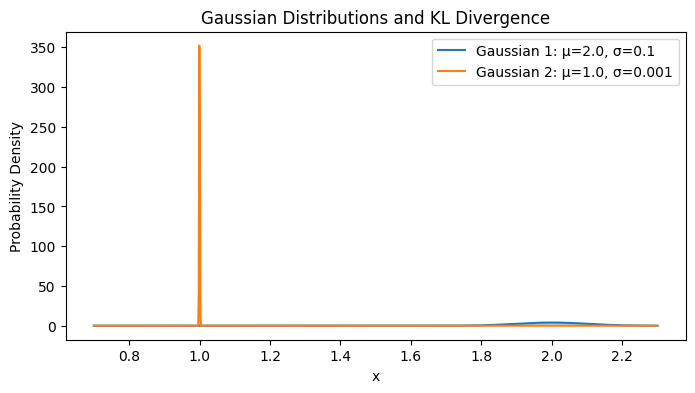

In [19]:
import torch
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

def visualize_and_compute_kl(mu1, sigma1, mu2, sigma2):
    # 创建两个一维高斯分布
    gaussian1 = dist.Normal(mu1, sigma1)
    gaussian2 = dist.Normal(mu2, sigma2)
    
    # 计算 KL 散度
    kl_div = dist.kl_divergence(gaussian1, gaussian2)
    print(f"KL Divergence: {kl_div.item()}")
    
    # 可视化两个分布
    x = np.linspace(min(mu1.item(), mu2.item()) - 3 * max(sigma1, sigma2), 
                    max(mu1.item(), mu2.item()) + 3 * max(sigma1, sigma2), 1000)
    y1 = np.exp(gaussian1.log_prob(torch.tensor(x)))
    y2 = np.exp(gaussian2.log_prob(torch.tensor(x)))
    
    plt.figure(figsize=(8, 4))
    plt.plot(x, y1, label=f'Gaussian 1: μ={mu1.item()}, σ={sigma1}')
    plt.plot(x, y2, label=f'Gaussian 2: μ={mu2.item()}, σ={sigma2}')
    plt.fill_between(x, y1, alpha=0.3)
    plt.fill_between(x, y2, alpha=0.3)
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("Probability Density")
    plt.title("Gaussian Distributions and KL Divergence")
    plt.show()

# 示例调用
mu1 = torch.tensor([2.0])
sigma1 = 0.1
mu2 = torch.tensor([1.0])
sigma2 = 1e-3

visualize_and_compute_kl(mu1, sigma1, mu2, sigma2)

In [6]:
low_level_planner_model_args = {
    
    'planner_alg': 'mmd',
    'use_guide_on_extra_objects_only': params.use_guide_on_extra_objects_only,
    'n_samples': params.n_samples,
    'n_local_inference_noising_steps': params.n_local_inference_noising_steps,
    'n_local_inference_denoising_steps': params.n_local_inference_denoising_steps,
    'start_guide_steps_fraction': params.start_guide_steps_fraction,
    'n_guide_steps': params.n_guide_steps,
    'n_diffusion_steps_without_noise': params.n_diffusion_steps_without_noise,
    'weight_grad_cost_collision': params.weight_grad_cost_collision,
    'weight_grad_cost_smoothness': params.weight_grad_cost_smoothness,
    'weight_grad_cost_constraints': params.weight_grad_cost_constraints,
    'weight_grad_cost_soft_constraints': params.weight_grad_cost_soft_constraints,
    'factor_num_interpolated_points_for_collision': params.factor_num_interpolated_points_for_collision,
    'trajectory_duration': params.trajectory_duration,
    'device': params.device,
    'debug': params.debug,
    'seed': params.seed,
    'results_dir': params.results_dir,
    'trained_models_dir': TRAINED_MODELS_DIR,
}

NameError: name 'params' is not defined

In [ ]:
from mmd.trainer import get_dataset, get_model
from mmd.models import TemporalUnet, UNET_DIM_MULTS

In [ ]:
model_dir = os.path.join(trained_models_dir, model_id)
args = load_params_from_yaml(os.path.join(model_dir, "args.yaml"))
# Load dataset with env, robot, task. The TrajectoryDataset type is used here.
train_subset, train_dataloader, val_subset, val_dataloader = get_dataset(
    dataset_class='TrajectoryDataset',
    use_extra_objects=True,
    obstacle_cutoff_margin=0.05,
    **args,
    tensor_args=tensor_args
)
# Extract objects from the dataset.
dataset = train_subset.dataset

In [ ]:
import torch
a = torch.randn((2,))

In [ ]:
diffusion_configs = dict(
    variance_schedule=args['variance_schedule'],
    n_diffusion_steps=args['n_diffusion_steps'],
    predict_epsilon=args['predict_epsilon'],
)
unet_configs = dict(
    state_dim=dataset.state_dim,
    n_support_points=dataset.n_support_points,
    unet_input_dim=args['unet_input_dim'],
    dim_mults=UNET_DIM_MULTS[args['unet_dim_mults_option']],
)
diffusion_model = get_model(
    model_class=args['diffusion_model_class'],
    model=TemporalUnet(**unet_configs),
    tensor_args=tensor_args,
    **diffusion_configs,
    **unet_configs
)